# Analysis Notebook for BenchExec Experiments

This notebook pre-processes the results obtained from Benchexec and plot it using seaborn.

In [9]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import dtale
import re

# sys.dont_write_bytecode = True  # prevent creation of .pyc files

CSV_FOLDER = "stats/"

## 1. Load data from CSV

Collect all CSV result files under `CSV_FOLDER` folder.

In [4]:
print(f"CSV files found in folder {CSV_FOLDER}:")
files = glob.glob(os.path.join(CSV_FOLDER, "**", "benchmark-*.csv"), recursive=True)

files

CSV files found in folder stats/:


['stats/july24-redo-benchexec/prp-19-07-24/benchmark-prp.2024-07-19_17-59-23.results.prp.FOND.csv',
 'stats/july24-redo-benchexec/paladinus-19-07-24/benchmark-paladinus.2024-07-19_07-50-23.results.paladinus.FOND.csv']

Load all CSV data into a single dataframe. Note that each CSV file may include results for many _run sets_, with each having its own columns. 

Each row is the result of a _task_ in the experiment, and every run set has its columns stats for such task. We then need to reshape this and just have one set of columns and the run set be another new column.

The first three lines contain header:

1. First line contains the _tool_ used. It starts with `tool` followed by the name of the tool repeated multiple times (to match no. of columns).
2. Second line contains the _runs_ of the experiment. It starts with `run set` and then sets of columns with the name of the runs.
3. Third line contains the _stats_ column names repeated per run set. First column is for name of the task.

An example with two runs `lpg` and `lpg_small`, using tool `PP-LPG`, is as follows:

```
tool	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 
run set	lpg	lpg	lpg	lpg	lpg	lpg	lpg	lpg_small	lpg_small	lpg_small	lpg_small	lpg_small	lpg_small	lpg_small
/home/nitin/app/benchmarks/benchexe/tasks/	status	cputime (s)	walltime (s)	memory (MB)	policy_size	solve_time	translation_time	status	cputime (s)	walltime (s)	memory (MB)	policy_size	solve_time	translation_time
AIJ_Barman_EIGHT50_1.yml	true	185.430462	185.5002005007118	295.952384	4966	185.0386784542352	0.263661066070199	true	16.422719	16.462604857981205	273.047552	4501	16.02331303898245	0.26572485268116
AIJ_Barman_EIGHT50_10.yml	true	94.405856	94.43696516938508	288.591872	5200	93.96452420670539	0.28180090803653	true	27.34709	27.380704921670258	276.148224	3846	26.93289530556649	0.26796702668070793
AIJ_Barman_EIGHT50_11.yml	false	1799.112512	1799.4882240109146	430.522368		-1	0.2723603779450059	true	550.644056	550.7977258479223	437.944320	48991	550.3052532738075	0.2680810196325183
AIJ_Barman_EIGHT50_12.yml	false	1799.168697	1799.4754690360278	457.166848		-1	0.2691544583067298	true	554.876223	555.0061234645545	416.649216	52499	554.5180832231417	0.2642196826636791
```




In [40]:
RENAME_COLS = {"benchmarks/benchexe/tasks/": "id", "cputime (s)": "cputime", "walltime (s)": "walltime", "memory (MB)": "memory_mb"}

def get_meta_csv(file):
    """Given a benchexec CSV file, extract the runs (e.g., prp, prp_inv) and how many columns per run"""
    with open(file, "r") as f:
        # first line contains the tool used (repeated one per column needed); e.g.,  PP-FOND
        tools_header = f.readline().split()[1:]
        # second line contains the run/solvers used in the experiment (e.g., prp, prp_inv) and starts with "run set" to be ignored
        runs_header = f.readline().split()[2:]

    runs = set(runs_header)

    no_cols = int(len(runs_header) / len(runs))

    return runs, no_cols


dfs = []
for f in files:
    runs, no_cols = get_meta_csv(f)
    print(f"Runs in file {f}: {runs} with {no_cols} stat columns")

    # go over each set of run columns (a csv file may contain many runs, each with the same columns)
    for k, r in enumerate(list(runs)):
        col_idx = [0] + list(range(k*no_cols + 1, k*no_cols + no_cols + 1))
        print(f"\t Extracting run '{r}' in columns: {col_idx}")

        # read the CSV file from line 3+ (line 3 is header)
        df = pd.read_csv(f, delimiter="\t", skiprows=2, usecols=col_idx)
        df.rename(columns=lambda x: x.split('.')[0], inplace=True)

        df.columns.values[0] = "task"
        # df.rename(columns={df.columns[1]: "task"})

        # populate column run with name of run-solver r
        df.insert(1, 'run', r)
        dfs.append(df)

df_csv = pd.concat(dfs).reset_index(drop=True)

df_csv.rename(columns=RENAME_COLS, inplace=True)

# df.set_index("task", inplace=True)
df_csv

Runs in file stats/july24-redo-benchexec/prp-19-07-24/benchmark-prp.2024-07-19_17-59-23.results.prp.FOND.csv: {'prp.FOND'} with 6 stat columns
	 Extracting run 'prp.FOND' in columns: [0, 1, 2, 3, 4, 5, 6]
Runs in file stats/july24-redo-benchexec/paladinus-19-07-24/benchmark-paladinus.2024-07-19_07-50-23.results.paladinus.FOND.csv: {'paladinus.FOND'} with 6 stat columns
	 Extracting run 'paladinus.FOND' in columns: [0, 1, 2, 3, 4, 5, 6]


,task,run,status,cputime,walltime,memory_mb,planner_time,policy_size
0,acrobatics_01.yml,prp.FOND,true,0.233342,0.235622,10.080256,0.01,4
1,acrobatics_02.yml,prp.FOND,true,10.369209,10.374620,10.199040,10.14,8
2,acrobatics_03.yml,prp.FOND,true,11.289586,11.302472,10.235904,11.05,16
3,acrobatics_04.yml,prp.FOND,true,12.004272,12.007289,10.444800,11.76,32
4,acrobatics_05.yml,prp.FOND,true,17.225556,17.242667,11.210752,16.95,64
...,...,...,...,...,...,...,...,...
1175,zenotravel_11.yml,paladinus.FOND,false,9445.659577,9446.366832,3274.539008,-1.00,-1
1176,zenotravel_12.yml,paladinus.FOND,false,10399.967062,10403.092858,3283.652608,-1.00,-1
1177,zenotravel_13.yml,paladinus.FOND,false,11708.166945,11709.024137,3278.856192,-1.00,-1
1178,zenotravel_14.yml,paladinus.FOND,false,12187.654604,12188.909141,3273.330688,-1.00,-1


We next **enrich** the dataframe with derived columns:

In [41]:
def get_benchmark_labels(task_name):
    """From the task description name (e.g., acrobatics_01.yml), extract the benchmark labels, like domain, instance"""
    regex = r"(.+)_([0-9]+)\.yml"

    match = re.match(regex, task_name)
    if match:
        # print(match.groups())
        domain = match.group(1)
        instance = match.group(2)
    else:
        print("Problem extracting labels from task name", task_name)
    return domain, instance

df = df_csv.copy()

# 1 - split task name into domain and instances
df["benchmark"] = df.reset_index()["task"].map(get_benchmark_labels).values
df["domain"] = df["benchmark"].str.get(0)
df["instance"] = df["benchmark"].str.get(1)
df.drop(columns=["benchmark"], inplace=True)

# 2 - map status from benchexec to integers status
map_status = {
    "true": 1,
    "false": 0,
    "OUT OF MEMORY (false)": -2,
    "TIMEOUT (false)": -1,
    "TIMEOUT (true)": 1,
}
df["status2"] = df["status"].map(map_status)

missing_mapping = df[df["status2"].isnull()].shape[0]
if missing_mapping > 0:
    print(f"WARNING: {missing_mapping} status values not mapped")
    print(df[df["status2"].isnull()])

df["status"] = df["status2"]
df.drop(columns=["status2"], inplace=True)

# 3 - define Boolean column solved to flag if solved or not based on status
df.insert(3, "solved", df["status"].apply(lambda x: True if x == 1 else False))


# 4 - extract solver from run name
map_solver = {
    "prp.FOND": "prp",
    "paladinus.FOND": "paladinus"
}
df["solver"] = df["run"].map(map_solver)







# sanity check status
# df.query("status not in [-1,0,-2,1]")
# df.status = df.status.astype(int) # convert to int
# df.loc[df.status == "OUT OF MEMORY (false)"]
# df.loc[df.status == -1]

# df.dtypes

# note that status should be integer; if float it is bc there must be NaN value!
df

,task,run,status,solved,cputime,walltime,memory_mb,planner_time,policy_size,domain,instance,solver
0,acrobatics_01.yml,prp.FOND,1,True,0.233342,0.235622,10.080256,0.01,4,acrobatics,01,prp
1,acrobatics_02.yml,prp.FOND,1,True,10.369209,10.374620,10.199040,10.14,8,acrobatics,02,prp
2,acrobatics_03.yml,prp.FOND,1,True,11.289586,11.302472,10.235904,11.05,16,acrobatics,03,prp
3,acrobatics_04.yml,prp.FOND,1,True,12.004272,12.007289,10.444800,11.76,32,acrobatics,04,prp
4,acrobatics_05.yml,prp.FOND,1,True,17.225556,17.242667,11.210752,16.95,64,acrobatics,05,prp
...,...,...,...,...,...,...,...,...,...,...,...,...
1175,zenotravel_11.yml,paladinus.FOND,0,False,9445.659577,9446.366832,3274.539008,-1.00,-1,zenotravel,11,paladinus
1176,zenotravel_12.yml,paladinus.FOND,0,False,10399.967062,10403.092858,3283.652608,-1.00,-1,zenotravel,12,paladinus
1177,zenotravel_13.yml,paladinus.FOND,0,False,11708.166945,11709.024137,3278.856192,-1.00,-1,zenotravel,13,paladinus
1178,zenotravel_14.yml,paladinus.FOND,0,False,12187.654604,12188.909141,3273.330688,-1.00,-1,zenotravel,14,paladinus


In [42]:
# solver/runs found
print("Solvers/run found:", df['solver'].unique())

Solvers/run found: ['prp' 'paladinus']


Finally, save all results into a complete CSV file.

In [16]:
# df.to_csv(os.path.join(CSV_FOLDER, "results_all.csv"), index=False)

## 2. Analysis example for set benchmark (e.g., AIJ, IJCAI, SOCS, etc.)

Fist select subset of interest (set and solver runs):

In [43]:
SOLVERS = df["solver"].unique()
DOMAINS = df["domain"].unique()

print("Solvers selected:", SOLVERS)
print("Domains selected:", DOMAINS)

df_sel = df.loc[(df.solver.isin(SOLVERS)) & (df.domain.isin(DOMAINS))]

df_sel = df

df_sel.head()

Solvers selected: ['prp' 'paladinus']
Domains selected: ['acrobatics' 'beam-walk' 'blocksworld-ipc08' 'blocksworld-new'
 'chain-of-rooms' 'doors' 'earth_observation' 'elevators' 'faults-ipc08'
 'first-responders-ipc08' 'islands' 'miner' 'spiky-tireworld'
 'tireworld-truck' 'tireworld' 'triangle-tireworld' 'zenotravel']


,task,run,status,solved,cputime,walltime,memory_mb,planner_time,policy_size,domain,instance,solver
0,acrobatics_01.yml,prp.FOND,1,True,0.233342,0.235622,10.080256,0.01,4,acrobatics,01,prp
1,acrobatics_02.yml,prp.FOND,1,True,10.369209,10.374620,10.199040,10.14,8,acrobatics,02,prp
2,acrobatics_03.yml,prp.FOND,1,True,11.289586,11.302472,10.235904,11.05,16,acrobatics,03,prp
3,acrobatics_04.yml,prp.FOND,1,True,12.004272,12.007289,10.444800,11.76,32,acrobatics,04,prp
4,acrobatics_05.yml,prp.FOND,1,True,17.225556,17.242667,11.210752,16.95,64,acrobatics,05,prp


Let's do a quick scattered plot for each class domain between solver run and cputime.

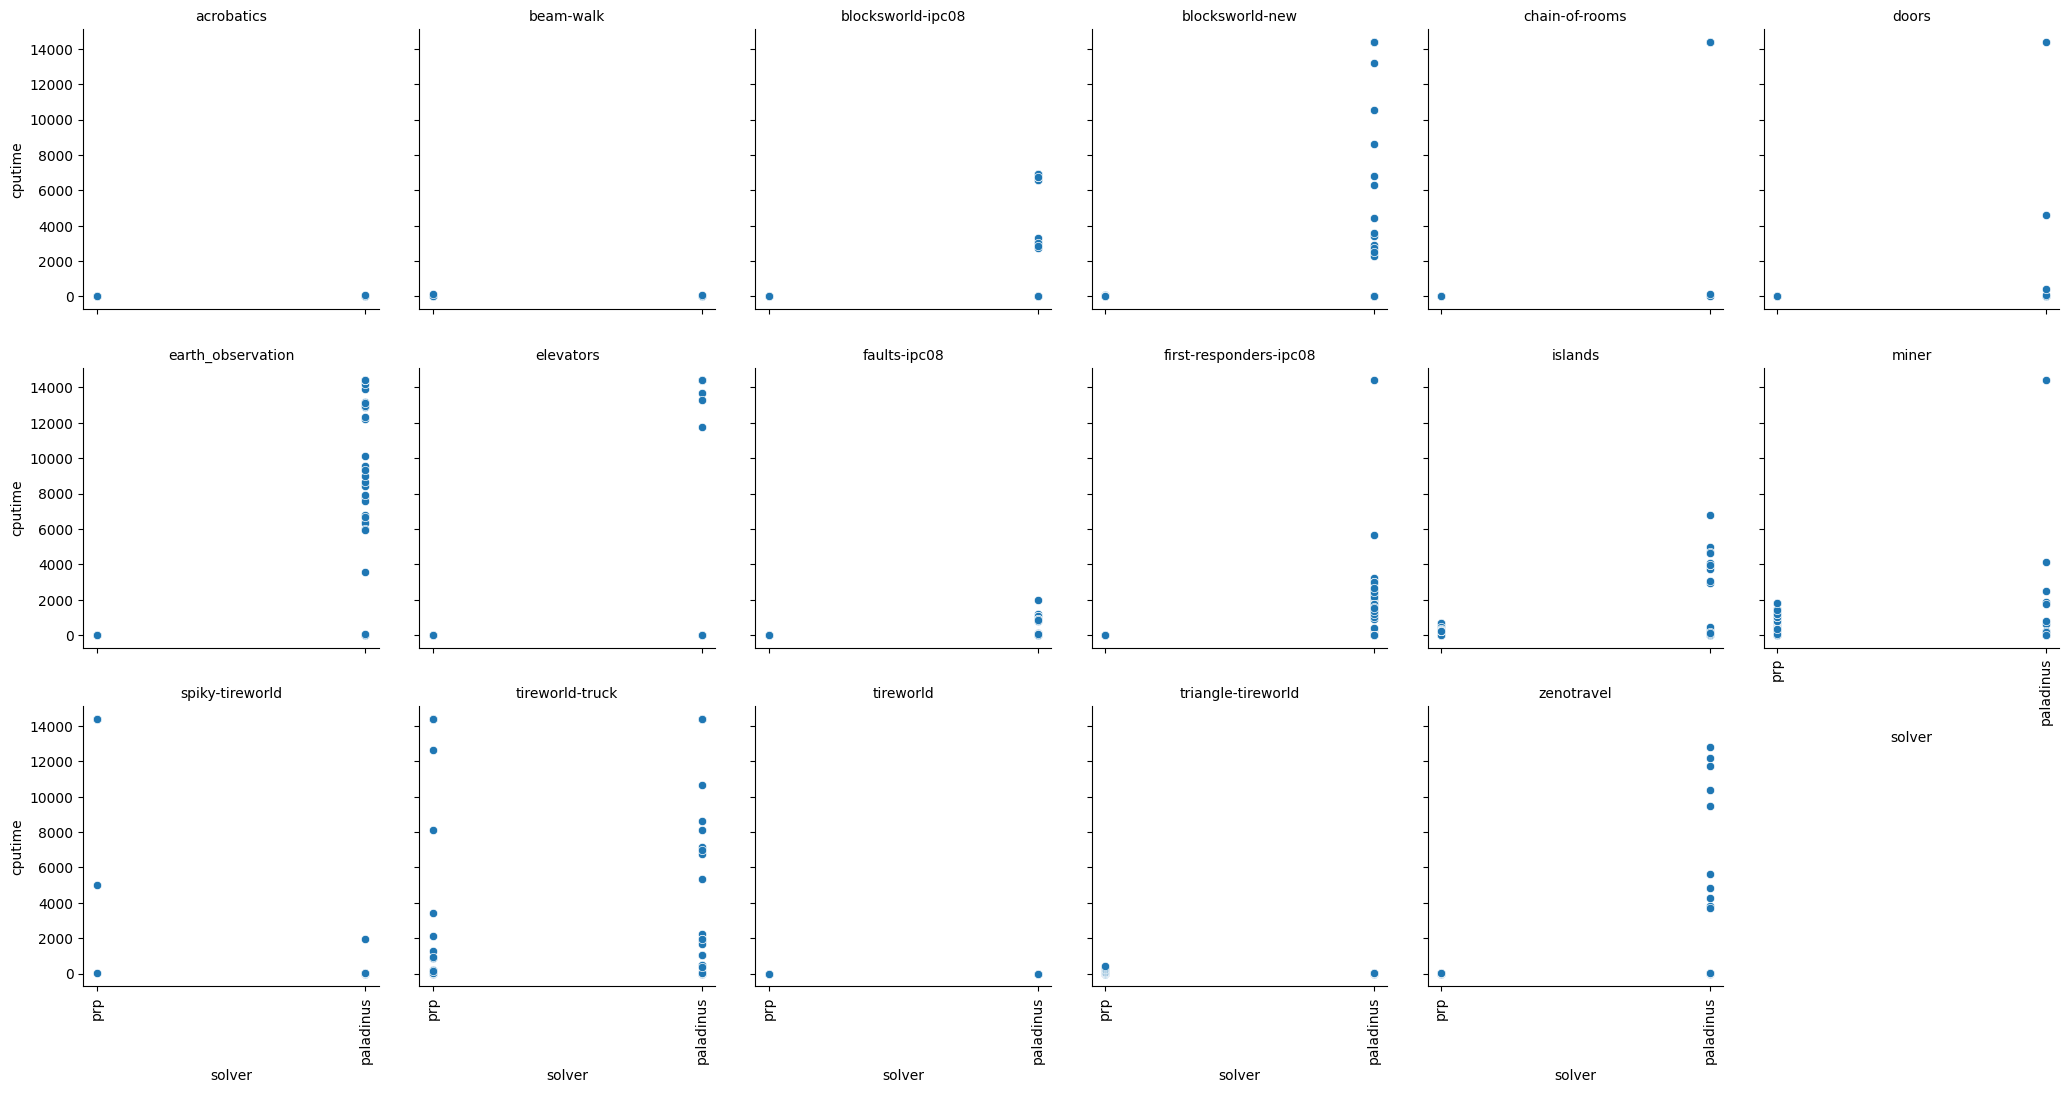

In [44]:
g = sns.relplot(data=df_sel, kind="scatter", x='solver',  y="cputime", col="domain",  col_wrap=6, height=3.5, aspect=1, legend=True)

g.set_titles(template='{col_name}',y=1)

# rotate x-labels
x_labels = g.axes[-1].get_xticklabels() # get x labels of last plot in grid (must have the labels!)
g.set_xticklabels(labels=x_labels, rotation=90)

### Time-Coverage chart for a SINGLE full domain (as in R)

In [47]:
# select full domain to consider
domain = "miner"

In [45]:
def compute_coverage(df: pd.DataFrame) -> pd.DataFrame:
    # columns to group-by
    selection_index = ['solver', 'domain']

    # count normalized (0-1) the number of grade after grouping for all the other values
    coverage_df = df.groupby(by=selection_index)["solved"].value_counts(normalize=True)

    # transofm the serie into a dataframe and value becomes percent
    coverage_df = coverage_df.mul(100).rename('percent').reset_index()


    # convert the rows that have 100% unsovable (False), to 0% solvable (True)
    #   otherwise, there will be no True solvable for those cases!
    mask_unsolvable = (~coverage_df.solved) & (coverage_df.percent == 100)
    coverage_df.loc[mask_unsolvable, ["solved", "percent"]] = [True, 0]

    # return the % of solvable stats
    return coverage_df.loc[coverage_df.solved].round(0)

compute_coverage(df)


,solver,domain,solved,percent
0,paladinus,acrobatics,True,100.0
1,paladinus,beam-walk,True,82.0
4,paladinus,blocksworld-ipc08,True,33.0
6,paladinus,blocksworld-new,True,15.0
8,paladinus,chain-of-rooms,True,20.0
9,paladinus,doors,True,100.0
11,paladinus,earth_observation,True,25.0
13,paladinus,elevators,True,47.0
14,paladinus,faults-ipc08,True,85.0
17,paladinus,first-responders-ipc08,True,30.0


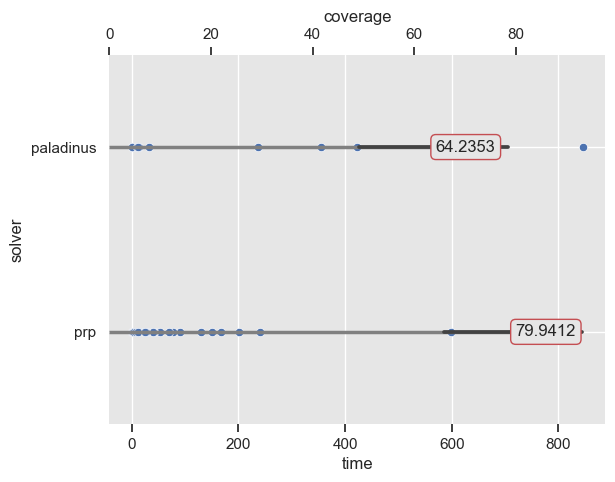

In [48]:
# https://seaborn.pydata.org/tutorial/aesthetics.html
# https://seaborn.pydata.org/generated/seaborn.set_theme.html
sns.set_theme()  
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

fig, ax = plt.subplots()

# FIRST graph for cputime per solver only on solved instances
sns.set_style("darkgrid")
g = sns.scatterplot(data=df_sel.query("solved and domain == @domain"), x='cputime', y='solver', ax=ax)
g.set_xlabel("time")


# SECOND overlapped graph for coverage per solver
sns.set_style("ticks")  # just ticks, no grid
ax2 = ax.twiny()    # get a twin y-axies https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html
g = sns.barplot(
    data=compute_coverage(df_sel).round(0),
    x="percent",
    y="solver",
    width=0.0001,
    linewidth=2.5,
    edgecolor=".5",
    facecolor=(0, 0, 0, 0),
    ax=ax2,
)
g.set_xlabel('coverage')

# Coverage % in a rounded box at the end of the bar
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar_label.html
# https://matplotlib.org/stable/api/text_api.html#matplotlib.text.Text
bbox = dict(boxstyle="round", fc="0.9", fill=True, color='r') # https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyBboxPatch.html#matplotlib.patches.FancyBboxPatch
ax2.bar_label(ax2.containers[0], padding=0, label_type='edge', fontweight='normal', mouseover=True, rotation="horizontal", bbox=bbox)


# changes the first bar itself
# https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html#matplotlib.patches.Rectangle
# ax2.containers[0].patches[0].set(linewidth=10)

# FINAL touches
sns.despine(left=True, bottom=True) # no spines at all

plt.show()

## 3. Time-coverage charts for ALL full domains in selected set benchmark

First get the set of interest:

In [161]:
SOLVERS = df["solver"].unique()
DOMAINS = df["domain"].unique()

print("Solvers selected:", SOLVERS)
print("Domains selected:", DOMAINS)

df_sel = df.loc[(df.solver.isin(SOLVERS)) & (df.domain.isin(DOMAINS))]

df_sel = df

df_sel.head()

Solvers selected: ['prp' 'paladinus']
Domains selected: ['acrobatics' 'beam-walk' 'blocksworld-ipc08' 'blocksworld-new'
 'chain-of-rooms' 'doors' 'earth_observation' 'elevators' 'faults-ipc08'
 'first-responders-ipc08' 'islands' 'miner' 'spiky-tireworld'
 'tireworld-truck' 'tireworld' 'triangle-tireworld' 'zenotravel']


,task,run,status,solved,cputime,walltime,memory_mb,planner_time,policy_size,domain,instance,solver
0,acrobatics_01.yml,prp.FOND,1,True,0.233342,0.235622,10.080256,0.01,4,acrobatics,01,prp
1,acrobatics_02.yml,prp.FOND,1,True,10.369209,10.374620,10.199040,10.14,8,acrobatics,02,prp
2,acrobatics_03.yml,prp.FOND,1,True,11.289586,11.302472,10.235904,11.05,16,acrobatics,03,prp
3,acrobatics_04.yml,prp.FOND,1,True,12.004272,12.007289,10.444800,11.76,32,acrobatics,04,prp
4,acrobatics_05.yml,prp.FOND,1,True,17.225556,17.242667,11.210752,16.95,64,acrobatics,05,prp


Count how MANY instances per full domain:

In [162]:
selection_index = ['domain']

# count the number of each run per full_domain (e.g., how many lpg runs in Barman-EIGHT50)
count_df = df_sel.groupby(by=selection_index)['solver'].value_counts()

count_df = count_df.reset_index(name="count")

# # transofm the serie into a dataframe and value becomes percent
# coverage_df = coverage_df.mul(100).round(0).rename('percent').reset_index()
# coverage_df = coverage_df.loc[coverage_df.status].reset_index(drop=True)    # keep just the TRUE status (solved!)

count_df
# count_df.query("domain == 'miner' or domain == 'tireworld'")

,domain,solver,count
0,acrobatics,paladinus,8
1,acrobatics,prp,8
2,beam-walk,paladinus,11
3,beam-walk,prp,11
4,blocksworld-ipc08,paladinus,30
5,blocksworld-ipc08,prp,30
6,blocksworld-new,paladinus,40
7,blocksworld-new,prp,40
8,chain-of-rooms,paladinus,10
9,chain-of-rooms,prp,10


Next calculate coverage for each solver run in each full domain:

In [163]:
# # merge with count of instances per full domain
coverage_df = compute_coverage(df_sel)
coverage_df = coverage_df.merge(count_df)
coverage_df

# SOME FILTERS
# coverage_df.query("not solved and percent == 100")
# coverage_df.query("solved and percent == 0")

,solver,domain,solved,percent,count
0,paladinus,acrobatics,True,100.0,8
1,paladinus,beam-walk,True,82.0,11
2,paladinus,blocksworld-ipc08,True,33.0,30
3,paladinus,blocksworld-new,True,15.0,40
4,paladinus,chain-of-rooms,True,20.0,10
5,paladinus,doors,True,100.0,15
6,paladinus,earth_observation,True,25.0,40
7,paladinus,elevators,True,47.0,15
8,paladinus,faults-ipc08,True,85.0,55
9,paladinus,first-responders-ipc08,True,30.0,100


Compute the CPU time mean per domain/solver.

In [164]:
selection_index = ["domain", "solver"]

# mean of cputime for SOLVED instances
cputime_mean_df = df_sel.loc[df_sel.solved].groupby(by=selection_index)["cputime"].mean().round(2)

# mean of cputime for ALL instances
# cputime_mean_df = df_sel.groupby(by=selection_index)["cputime"].mean()

cputime_mean_df = cputime_mean_df.reset_index(name="cputime_mean")

cputime_mean_df

,domain,solver,cputime_mean
0,acrobatics,paladinus,11.18
1,acrobatics,prp,13.01
2,beam-walk,paladinus,1.39
3,beam-walk,prp,21.18
4,blocksworld-ipc08,paladinus,2.26
5,blocksworld-ipc08,prp,1.12
6,blocksworld-new,paladinus,5.11
7,blocksworld-new,prp,17.45
8,chain-of-rooms,paladinus,60.14
9,chain-of-rooms,prp,0.85


In [165]:
coverage_df = coverage_df.merge(cputime_mean_df)

coverage_df

,solver,domain,solved,percent,count,cputime_mean
0,paladinus,acrobatics,True,100.0,8,11.18
1,paladinus,beam-walk,True,82.0,11,1.39
2,paladinus,blocksworld-ipc08,True,33.0,30,2.26
3,paladinus,blocksworld-new,True,15.0,40,5.11
4,paladinus,chain-of-rooms,True,20.0,10,60.14
5,paladinus,doors,True,100.0,15,1304.16
6,paladinus,earth_observation,True,25.0,40,361.16
7,paladinus,elevators,True,47.0,15,5.48
8,paladinus,faults-ipc08,True,85.0,55,10.67
9,paladinus,first-responders-ipc08,True,30.0,100,53.99


Let's check the coverage in a particular full domain:

In [166]:
import random

x = random.choice(coverage_df['domain'].unique())
coverage_df.loc[coverage_df.domain == x]

,solver,domain,solved,percent,count,cputime_mean
13,paladinus,tireworld,True,80.0,15,0.64
30,prp,tireworld,True,80.0,15,0.30


Some useful links to make nice charts:

* [Changing plot style and color](https://s3.amazonaws.com/assets.datacamp.com/production/course_15192/slides/chapter4.pdf).
* [Advanced Seaborn: Demystifying the Complex Plots!](https://levelup.gitconnected.com/advanced-seaborn-demystifying-the-complex-plots-537582977c8c#5965 )

OK this is the main code for drawing complex combined time-coverage charts across a full set benchmark (e.g., AIJ) as done with the R's script. 

For each full domain (e.g., Barman-EIGHT50), draw a plot showing scatter time performance across instances per solver/run AND coverage bars superimposed. This was Nitin's great graphs done originally in R for ECAI'23.

In each subplot, the title shows the full domain with the number of instances run (e.g., "Barman-EIGHT50 (20)": 20 instances run for Barman-EIGHT50 full domain).

Finished building scattered plot of cputime. Next overlapping coverage bars...


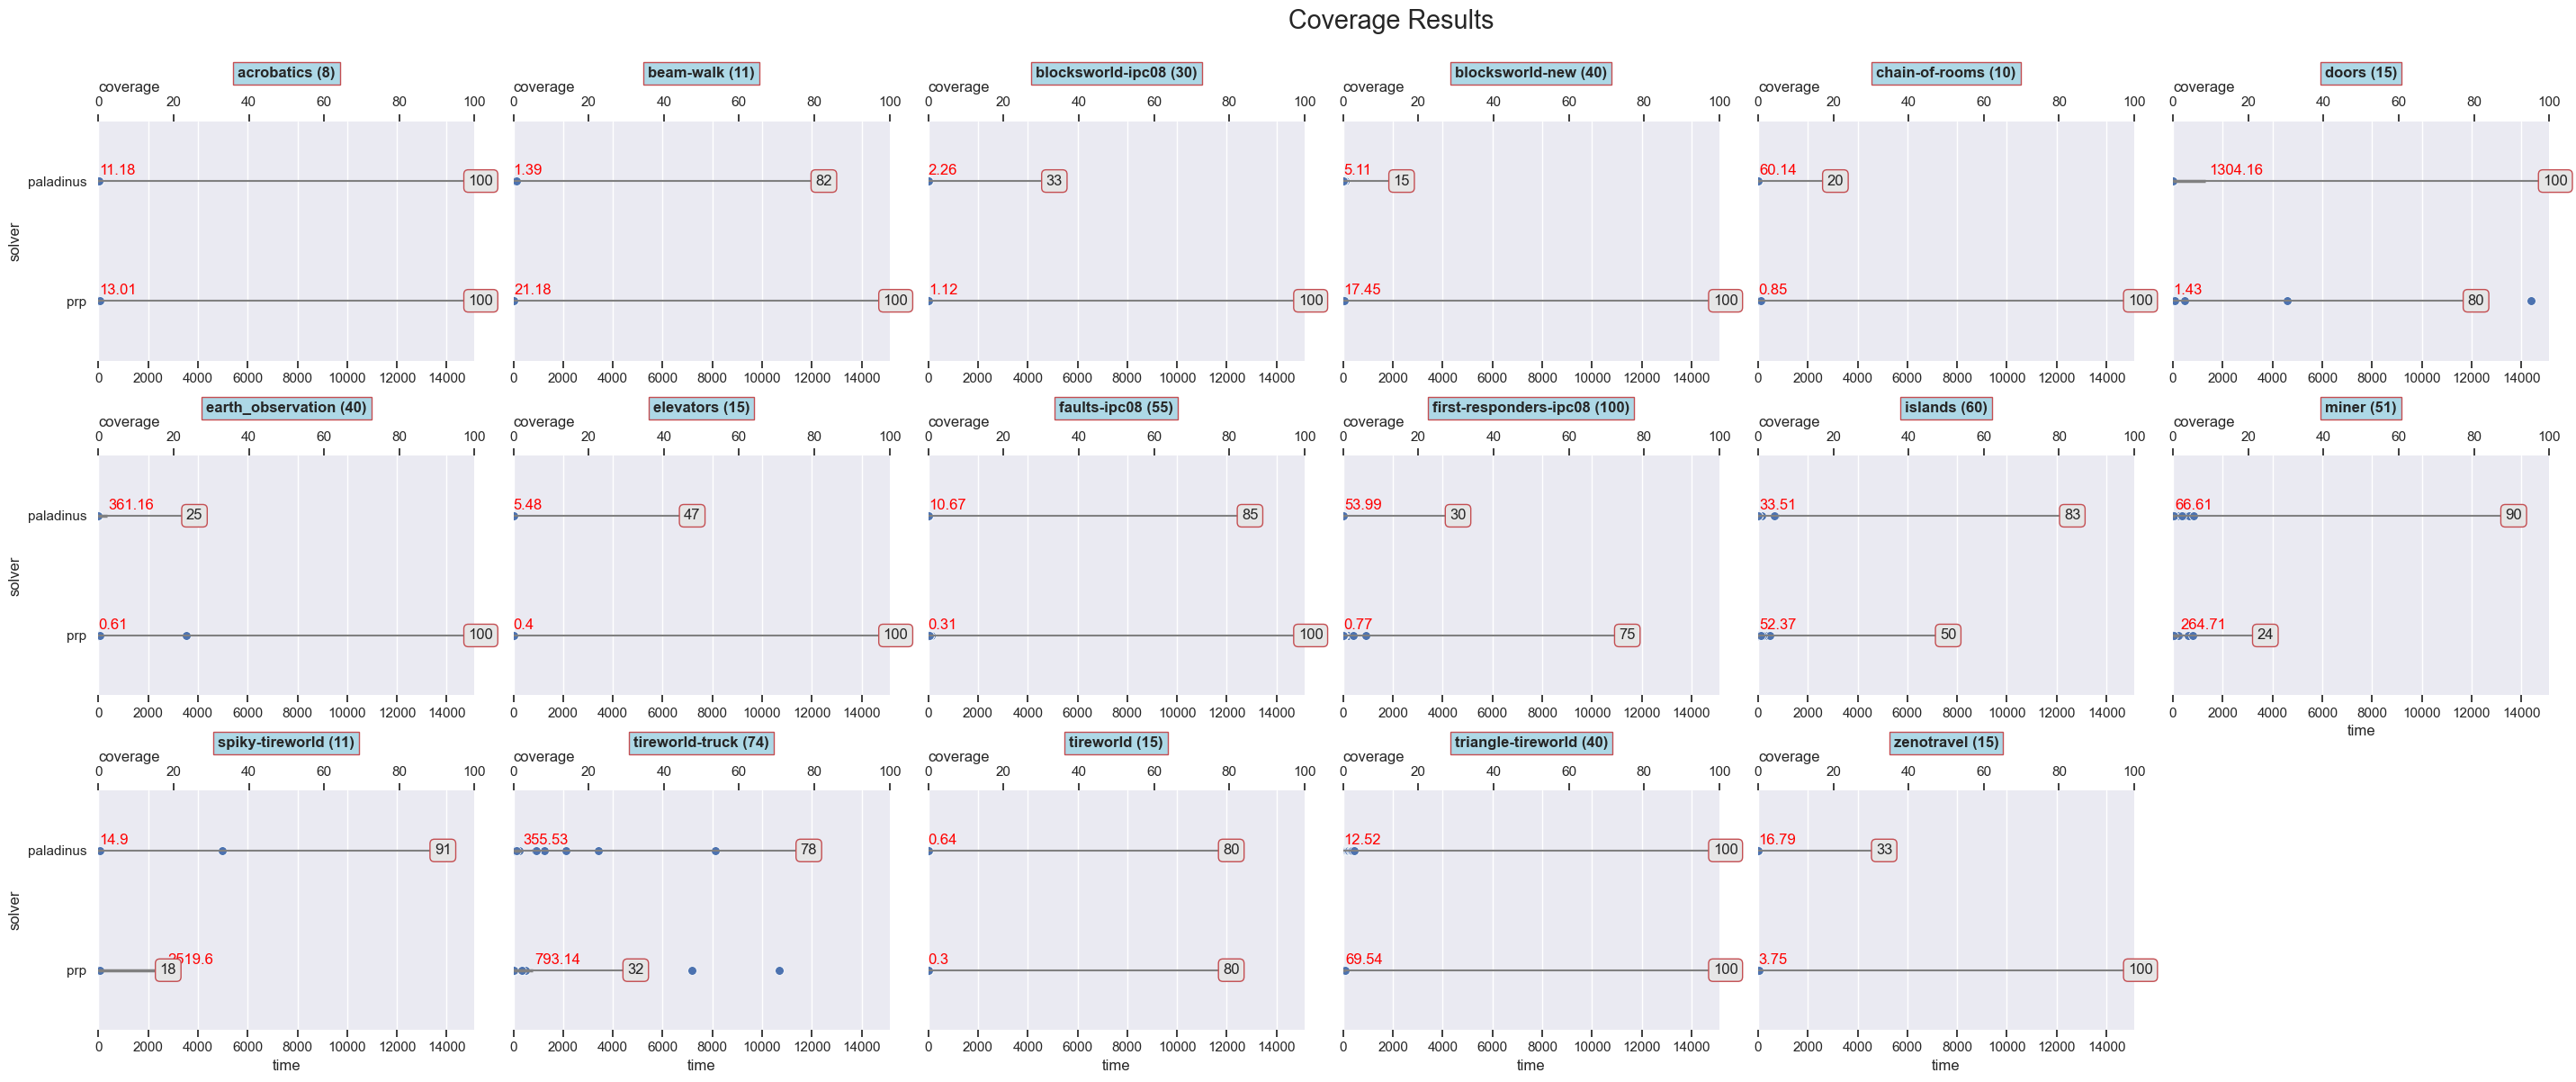

In [227]:
# https://seaborn.pydata.org/tutorial/aesthetics.html
# https://seaborn.pydata.org/generated/seaborn.set_theme.html
sns.set_theme()
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_style("darkgrid")

# DEFINE BOXES USED BELOW
# box for the title of each subplot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyBboxPatch.html#matplotlib.patches.FancyBboxPatch
bbox_title = dict(boxstyle="square", fc="lightblue", fill=True, color="r")
bbox_coverage = dict(boxstyle="round", fc="0.9", fill=True, color="r")
bbox_cputime = dict(boxstyle=None, fc="0.9", fill=True, color="r")

####################################################################################
## FIRST, produce one scatter subplot per domain with x=cputime and y=solver
# https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot
####################################################################################
g = sns.relplot(
    data=df_sel.query("solved"),
    kind="scatter",
    s=50,
    x="cputime",
    y="solver",
    col="domain",  # one subplot per domain
    col_wrap=6,
    height=4,
    aspect=1.2,
)

# Let's set titles
g.set_axis_labels("time", "solver")
g.set_titles(  #   most options are passed to text: https://matplotlib.org/stable/api/text_api.html
    col_template="{col_name}",
    fontweight="demibold",
    ha="center",
    va="center",
    bbox=bbox_title,
)
g.figure.suptitle(
    f"Coverage Results", ha="left", va="top", fontsize="xx-large", y=1
)  # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.suptitle.html


print("Finished building scattered plot of cputime. Next overlapping coverage bars...")

# get all the axes (subplots) of the FaceGrid
axes = g.axes.flatten()
sns.set_style("ticks")  # just ticks, no grid from now on...

####################################################################################
# SECOND, super-impose cputime mean numbers per solver in each subplot in the grid
#  #TODO: at this point I don't know to shift the number a bit up!
####################################################################################
for ax in axes:
    domain = ax.get_title()
    g_cpumean = sns.barplot(  # draw the bar of mean cputime per solver
        data=coverage_df[coverage_df.domain.eq(domain)],
        x="cputime_mean",
        y="solver",
        width=0.0001,
        linewidth=2.5,
        edgecolor=".5",
        facecolor=(0, 0, 0, 0),
        ax=ax,
    )
    g_cpumean.set(xlabel=None)

    # add cpu mean number per solver, but a bit up to not clash with coverage bar!
    # https://stackoverflow.com/questions/70693878/flexible-placement-of-labels-in-seaborn-barplots
    for p in ax.patches:
        perc = p.get_width()  # the label for the bar
        x = p.get_width()
        y = p.get_y() + p.get_height() / 2

        ax.annotate(perc, (x * 1.1, y - 0.05), color="red")

    # this will add the cpu mean per solver, but will clash with the coverage bar!
    # if len(ax.containers) > 0: # may not be no number!
    #     ax.bar_label(  # set the mean number in the bar at the end (cannot shift tup!)
    #         ax.containers[0],
    #         fmt="%.2f",
    #         label_type="edge",
    #         padding=5,
    #         fontweight="normal",
    #         rotation="horizontal",
    # )


####################################################################################
## THIRD, super-impose the COVERAGE data in each subplot in the grid as done in
#   https://stackoverflow.com/a/67612124
#   we also rename the title of each subplot to include no of instances run
#   we iterate on each axis and plot a barplot and add annotations/styles to it
####################################################################################
for ax in axes:
    # redo title of subfigure to include number of instances between parenthesis, e.g., BARMAN-EIGHT50 (20)
    domain = ax.get_title()
    no_instances = coverage_df.loc[coverage_df.domain == ax.get_title()][
        "count"
    ].unique()[0]
    ax.set_title(
        f"{domain} ({no_instances})",
        fontweight="demibold",
        ha="center",
        va="center",
        bbox=bbox_title,
    )

    # add bar of coverage % for each run/solver
    ax2 = (
        ax.twiny()
    )  # get a twin y-axies https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html
    g2 = sns.barplot(
        data=coverage_df[coverage_df.domain.eq(domain)],
        x="percent",
        y="solver",
        width=0.0001,
        linewidth=1.5,
        edgecolor=".5",
        facecolor=(0, 0, 0, 0),
        ax=ax2,
    )
    g2.set_xlabel("coverage", x=0, ha="left")
    g2.set_xlim([0, 100])

    # add box with % of coverage at the end of the barline, if any!
    if len(ax2.containers) > 0:
        ax2.bar_label(
            ax2.containers[0],
            label_type="edge",
            padding=-5,
            fontweight="normal",
            rotation="horizontal",
            bbox=bbox_coverage,
        )

# set the axis labels for the whole plot
g.set_axis_labels("time", "solver")

# axes[0].legend().remove()
# g.set_axis_labels(x_var=None, y_var=None, clear_inner=True)
sns.despine(left=True, bottom=True)  # no spines at all

# Save it later, not here.
# plt.savefig(os.path.join(CSV_FOLDER, f"{SET}_plot.png"))

plt.tight_layout()  # at the end adjust so everything fits tight but well
plt.show()

Double check some of the numbers there to make sure they match!

In [222]:
df_sel.query("solver == 'prp' and domain == 'islands' and solved")['cputime'].mean()

52.36683976666667

Save graph in a PNG file:

In [39]:
g.savefig(os.path.join(CSV_FOLDER, f"{SET}_plot.png"))

## 4. Coverage Analysis

We now generate **coverage** tables, as they often apper in papers. Basically we compute per benchmark set, domain, and APP type sub-domain, and each solver-run:

- **Coverage:** % of solved instances solved by the solver-run; and
- **Stat metrics:** mean on time, memory usage, and policy size.

In [31]:
df = pd.read_csv(os.path.join(CSV_FOLDER,"results_all.csv"))

print(df.shape)
df.head()

(9080, 15)


,task,run,status,solved,cputime,walltime,memory_mb,policy_size,solve_time,translation_time,set,domain,sub_domain,full_domain,instance
0,AIJ_Barman_EIGHT50_1.yml,prp2,true,True,68.124683,68.197424,85.495808,1247.0,67.743483,0.277062,AIJ,Barman,EIGHT50,Barman-EIGHT50,1
1,AIJ_Barman_EIGHT50_10.yml,prp2,true,True,50.088596,50.107441,82.214912,4965.0,49.649540,0.279914,AIJ,Barman,EIGHT50,Barman-EIGHT50,10
2,AIJ_Barman_EIGHT50_11.yml,prp2,true,True,953.906555,954.042272,461.467648,74468.0,953.584711,0.279725,AIJ,Barman,EIGHT50,Barman-EIGHT50,11
3,AIJ_Barman_EIGHT50_12.yml,prp2,true,True,868.641473,868.775420,462.823424,77181.0,868.312224,0.280933,AIJ,Barman,EIGHT50,Barman-EIGHT50,12
4,AIJ_Barman_EIGHT50_13.yml,prp2,true,True,93.838403,93.852691,192.663552,30050.0,93.396514,0.279126,AIJ,Barman,EIGHT50,Barman-EIGHT50,13


Calculate % ratio per set/domain/sub_domain/run-solver.

In [32]:
df_grouped = df.groupby(["set", "domain", "sub_domain", "run"])

#   df_grouped.sum()[["solved"]] = sum all the True instances (sum over bool = number of True)
#   df_grouped.count()[["solved"]] = number of rows in solved column (includes True and Talse values)
df_coverage = df_grouped.sum()[["solved"]] / df_grouped.count()[["solved"]]
df_coverage

solved
set  domain     sub_domain run              
AIJ  Barman     EIGHT50    lpg          1.00
                           lpg_small    0.50
                           prp          1.00
                           prp2         1.00
                           prp2_inv0    1.00
...                                      ...
SOCS ZenoTravel STL5-43    lpg_small    0.15
                           prp          0.20
                           prp2         0.10
                           prp2_inv0    0.10
                           prp_inv0     0.20

[416 rows x 1 columns]

Calculate mean metric (for CPU time, memory, and policy size) across the solved instances.

In [25]:
columns = ["domain", "sub_domain", "run", "cputime", "memory_mb", "policy_size"]
df_solved = df.query("solved == True")[columns]

df_solved_grouped = df_solved.groupby(["domain", "sub_domain", "run"])
df_metrics = df_solved_grouped.mean()
df_metrics

cputime   memory_mb  policy_size
domain     sub_domain run                                           
Airport               lpg          1.957297  290.117888    92.937500
                      lpg_small    1.903120  289.821764    96.066667
                      paladinus    4.156144  159.891456    42.500000
                      prp         12.893395  157.106417   118.588235
                      prp2        56.927918  123.730688   117.187500
...                                     ...         ...          ...
ZenoTravel STL5-43    lpg_small   31.635788  306.262016    86.333333
                      prp        256.557254  185.479168    94.000000
                      prp2         0.778649   38.668288    66.000000
                      prp2_inv0    0.729787   38.959104    63.000000
                      prp_inv0   247.463489  185.498624    94.000000

[347 rows x 3 columns]

Put together **Coverage** and **Metrics** tables.

In [26]:
column_names = {
    "solved": "cov",
    "cputime": "time",
    "memory_mb": "mem",
    "policy_size": "size",
}

df_stats = df_coverage.join(df_metrics, how="inner")
df_stats.rename(columns=column_names, inplace=True)

df_stats = df_stats.reset_index()
df_stats.insert(0, "set", df_stats.pop("set"))

df_stats

NameError: name 'df_coverage' is not defined

In [114]:
df_stats_pivot = df_stats.pivot(
    index=["set", "domain", "sub_domain"],
    values=["cov", "time", "mem", "size"],
    columns="run",
)
df_stats_pivot.reset_index(
    inplace=True
)  # unfold multi-index into columns (create integer index)
df_stats_pivot.columns = [
    "_".join(tup).rstrip("_") for tup in df_stats_pivot.columns.values
]

# flat index, but multi-column: 1. coverage / time / policy size and 2. each solver/run
df_stats_pivot = df_stats_pivot.round(2)

df_stats_pivot

,set,domain,sub_domain,cov_lpg,cov_lpg_small,cov_prp,cov_prp2,cov_prp2_inv0,cov_prp_inv0,time_lpg,...,mem_prp,mem_prp2,mem_prp2_inv0,mem_prp_inv0,size_lpg,size_lpg_small,size_prp,size_prp2,size_prp2_inv0,size_prp_inv0
0,AIJ,Barman,EIGHT50,1.00,0.50,1.00,1.00,1.00,0.80,125.35,...,263.04,128.24,152.99,62.21,13018.35,24468.70,1854.60,14486.00,7096.90,2400.00
1,AIJ,Barman,RING50,1.00,0.95,1.00,1.00,1.00,1.00,10.57,...,242.81,51.33,247.64,41.76,1858.75,1829.63,665.75,941.30,631.85,1022.55
2,AIJ,Barman,RND50,0.55,0.25,0.70,0.75,0.75,0.45,244.70,...,119.94,176.40,90.87,148.50,34688.64,28568.20,2788.21,22645.33,6701.20,3852.22
3,AIJ,Barman,SCC56,0.35,0.10,0.60,0.30,0.75,0.25,100.46,...,104.48,106.80,105.18,45.43,24015.71,37293.50,3484.25,10391.50,15002.07,2297.60
4,AIJ,BlocksWorld,EIGHT4-51,1.00,1.00,1.00,1.00,1.00,1.00,4.21,...,175.98,39.44,213.95,104.86,106.53,98.82,207.94,233.53,233.65,207.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,SOCS,ZenoTravel,RND3-23,0.10,0.15,0.35,0.10,0.10,0.35,250.75,...,148.62,38.48,38.50,148.67,192.50,168.00,1378.86,325.50,320.00,1378.86
66,SOCS,ZenoTravel,RND54,0.65,0.80,0.90,0.35,0.25,0.90,57.08,...,672.92,117.64,144.74,672.87,6886.69,3940.56,5957.83,2833.14,5575.00,5957.83
67,SOCS,ZenoTravel,SCC3-11,0.11,0.11,0.33,NaN,0.11,0.33,437.43,...,67.05,NaN,94.21,67.08,186.00,275.00,1318.67,NaN,419.00,1318.67
68,SOCS,ZenoTravel,SCC56,0.25,0.35,0.45,0.05,0.05,0.45,78.22,...,516.77,115.50,113.44,557.39,6285.36,4713.96,11441.89,8313.00,7389.00,11154.75


Save it to the file, this can be used in the paper.

In [115]:
df_stats_pivot.to_csv(os.path.join(CSV_FOLDER, "results_stats.csv"), index=False)